In [5]:
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt

Saved: graphics/speed_vs_sample_size_grid.png
Saved: graphics/speed_vs_sample_size_grid.jpg
Saved: graphics/speed_vs_sample_size_grid.pdf


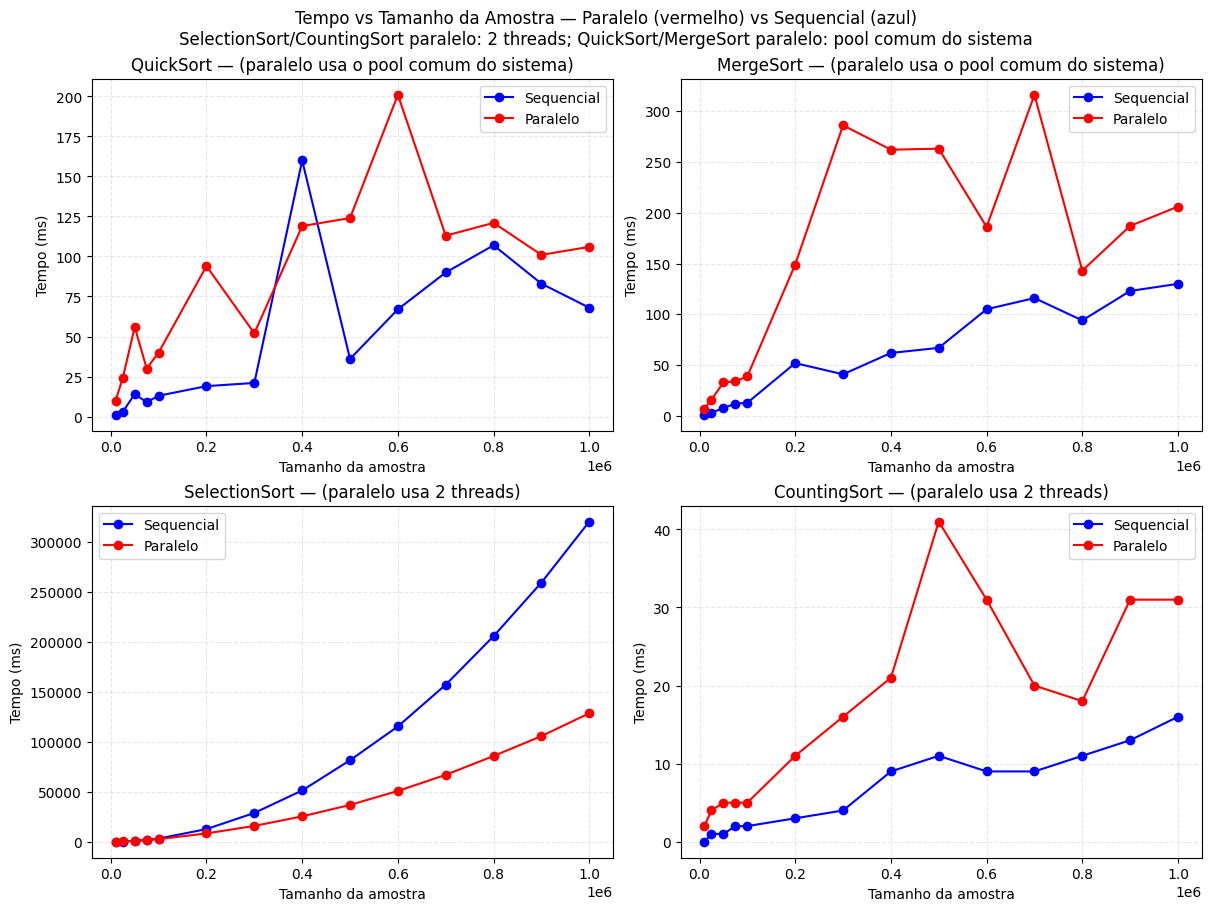

In [6]:
local_path = Path.cwd().resolve()
data_dir = local_path.joinpath('data').resolve()
csv_paths = sorted(data_dir.glob('*-sample.csv'))
if not csv_paths:
    raise FileNotFoundError(f'Nenhum arquivo CSV encontrado em {data_dir}')

frames: list[pl.DataFrame] = []
for p in csv_paths:
    df = pl.read_csv(p)
    df = df.with_columns([
        pl.col('implentation_name').cast(pl.Utf8),
        pl.col('time').cast(pl.Float64),
        pl.col('sample_size').cast(pl.Int64),
    ])
    frames.append(df)

all_df = pl.concat(frames, how='vertical')

agg_df = (
    all_df
    .group_by(['sample_size', 'implentation_name'])
    .agg(pl.col('time').mean().alias('time'))
    .sort(['sample_size', 'implentation_name'])
)

algorithms = ['QuickSort', 'MergeSort', 'SelectionSort', 'CountingSort']
pairs = {
    'QuickSort':    {'seq': 'QuickSort sequencial',    'par': 'QuickSort paralelo',    'note': '(paralelo usa o pool comum do sistema)'},
    'MergeSort':    {'seq': 'MergeSort sequencial',    'par': 'MergeSort paralelo',    'note': '(paralelo usa o pool comum do sistema)'},
    'SelectionSort':{'seq': 'SelectionSort sequencial','par': 'SelectionSort paralelo','note': '(paralelo usa 2 threads)'},
    'CountingSort': {'seq': 'CountingSort sequencial', 'par': 'CountingSort paralelo', 'note': '(paralelo usa 2 threads)'}
}

fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)
axes = axes.ravel()

for idx, algo in enumerate(algorithms):
    ax = axes[idx]
    names = pairs[algo]
    seq_name = names['seq']
    par_name = names['par']

    seq_df = (
        agg_df
        .filter(pl.col('implentation_name') == seq_name)
        .sort('sample_size')
    )
    par_df = (
        agg_df
        .filter(pl.col('implentation_name') == par_name)
        .sort('sample_size')
    )

    if seq_df.height == 0 and par_df.height == 0:
        ax.text(0.5, 0.5, f'Sem dados para {algo}', ha='center', va='center')
        ax.set_axis_off()
        continue

    if seq_df.height:
        ax.plot(seq_df['sample_size'], seq_df['time'], color='blue', marker='o', label='Sequencial')
    if par_df.height:
        ax.plot(par_df['sample_size'], par_df['time'], color='red', marker='o', label='Paralelo')

    ax.set_title(f'{algo} — {names["note"]}')
    ax.set_xlabel('Tamanho da amostra')
    ax.set_ylabel('Tempo (ms)')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

fig.suptitle(
    'Tempo vs Tamanho da Amostra — Paralelo (vermelho) vs Sequencial (azul)\n'
    'SelectionSort/CountingSort paralelo: 2 threads; QuickSort/MergeSort paralelo: pool comum do sistema',
    fontsize=12
)

out_dir = Path('graphics')
out_dir.mkdir(parents=True, exist_ok=True)
for ext in ['png', 'jpg', 'pdf']:
    out_path = out_dir / f'speed_vs_sample_size_grid.{ext}'
    fig.savefig(out_path, dpi=300 if ext in ('png','jpg') else None, bbox_inches='tight')
    print(f'Saved: {out_path}')

plt.show()
